<H1><center>Neural Architecture Search using MCGRAN</center></H1>

# Multi-conditional GRAN

We model the conditional graph generation as an affine transformation based on given contraints.
We use $ \textrm{MLP}_{scale} $ and $ \textrm{MLP}_{shift} $ to geometrically transform the feature space of bernoulli mixture components.
Our intention with this transformation is to separate the various constraints(classes or categories) of graphs into distinct real space.

\begin{align}
	\alpha_{1},..., \alpha_{K} = \textrm{Softmax}(\sum_{i \in \boldsymbol{b}_{t},1 \leq j \leq i} \textrm{MLP}_{\alpha} (h_{i}^{R} - h_{j}^{R}) \otimes \textrm{MLP}_{scale}(c_{i}) + \textrm{MLP}_{shift}(c_{i}))
\end{align}

\begin{align}
	\theta_{1,i,j},..., \theta_{K,i,j} = \textrm{Sigmoid}(\textrm{MLP}_{\theta} (h_{i}^{R} - h_{j}^{R})  \otimes \textrm{MLP}_{scale}(c_{i}) + \textrm{MLP}_{shift}(c_{i}))
\end{align}

In equations, $ M $ denote the number of constraints enforced on each node $ i $, $ c_{i} \in \mathbb{R}^{M} $ represents the constraints vector associated with each node $ i $, $ \textrm{MLP}_{scale} \in  \mathbb{R}^{K \times H}$ is a RELU-based hidden layer capturing features for scaling factor, and $ \textrm{MLP}_{shift} \in  \mathbb{R}^{K \times H} $ is a RELU-based hidden layer capturing features for shift factor. $ K $ denote the number of mixture components and $ H $ denote the hidden dimension size.

# Graph-based Auto-regressive Affine Transformations

Using the structure of the graph, that is, the adjacency matrix $ A $ for each graph $G = (V,E)$. We create node level features using 1D convolutions. We use a block of three 1D convolutional hidden layers stacked together to capture features for each vertices $ v $, where $ \textrm{CNN}(A): \mathbb{R}^{|V| \times |V|} \rightarrow \mathbb{R}^{|V| \times H}$, where adjacency matrix denoted as $ A \in \mathbb{R}^{|V| \times |V|} $. Each channel of convolution captures the information specific to a node.

Then, we apply auto-regressive affine transformation to create node labels.  In graph-based auto-regressive affine transformations, for each node label prediction, we use three information.  First information comes from the node features which we captured using the CNN. Let us denote node features for a node $v\in V$ as $q_v\in\mathbb{R}^{H}$ with $H$ being the feature dimension.

Second information comes from the nodes features of the other connected nodes. This acts as neighbor constraints to predict the current node label. For a node $v\in V$ of a graph $G = (V,E)$ its set of neighboring features is given as
\[
Neigh(v) = \{ q_s ~|~ (s,v) \in E \}
\]
We could also define $NAgg(v): \mathbb{R}^{|Neigh(v)| \times H} \rightarrow \mathbb{R}^{H}$

\begin{align}
	NAgg(v) = \sum\limits_{q\in\{ q_s ~|~ (s,v) \in E \}}
\end{align}

For each node $ v $, we apply affine transformation based on node neighbors with one scaling factor $ \textrm{MLP}_{scale}(NAgg(v)) $ and one shift factor $ \textrm{MLP}_{shift}(NAgg(v)) $. 

Third information comes from the graph level constraint. We apply geometric transformation based on graph constraints with one scaling factor  $ \textrm{MLP}_{scale}(c_{v}) $ and one shift factor $ \textrm{MLP}_{shift}(c_{v}) $.

The $ c_{v} \in \mathbb{R}^{M} $ represents the constraints vector associated with each node $ v $, the $ M $ denote the number of constraints enforced on each node $ v $, the $ \textrm{MLP}_{scale} \in  \mathbb{R}^{H}$ is a RELU-based hidden layer capturing features for scaling factor, and the $ \textrm{MLP}_{shift} \in  \mathbb{R}^{ H} $ is a RELU-based hidden layer capturing features for shift factor. The $ H $ denote the hidden dimension size.

%From a social network perspective, each person (node) uses the information he or she knows, then collects information from his or her friends, and finally collects information other sources (books or internet) to make a decision.
%The same process is applied here.

We can combine all three information to predict for each node $ v $ the label as shown in equation~\ref{eq:mcgran_node_label_equation}.

\begin{align}
	v = \textrm{Softmax}(\textrm{CNN}(v) \otimes \textrm{MLP}_{scale}(NAgg(v)) \otimes \textrm{MLP}_{scale}(c_{v})   + \textrm{MLP}_{shift}(NAgg(v)) + \textrm{MLP}_{shift}(c_{v}))
\end{align}

In [10]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [11]:
!pip install torch==1.11.0+cu113 torchvision==0.12.0+cu113 torchaudio==0.11.0 --extra-index-url https://download.pytorch.org/whl/cu113

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/, https://download.pytorch.org/whl/cu113
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 1.6/1.6 GB 109.6 MB/s eta 0:00:01tcmalloc: large alloc 1636999168 bytes == 0x2e16000 @  0x7f7f2783b680 0x7f7f2785c824 0x5b3128 0x5bbc90 0x5f714c 0x64d800 0x527022 0x504866 0x56bbe1 0x569d8a 0x5f60c3 0x56bbe1 0x569d8a 0x5f60c3 0x56bbe1 0x569d8a 0x5f60c3 0x56bbe1 0x569d8a 0x5f60c3 0x56bbe1 0x569d8a 0x5f60c3 0x56bbe1 0x5f5ee6 0x56bbe1 0x569d8a 0x5f60c3 0x56cc92 0x569d8a 0x5f60c3
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 1.6/1.6 GB 129.3 MB/s eta 0:00:01tcmalloc: large alloc 2046255104 bytes == 0x64740000 @  0x7f7f2783b680 0x7f7f2785bda2 0x5f714c 0x64d800 0x527022 0x504866 0x56bbe1 0x569d8a 0x5f60c3 0x56bbe1 0x569d8a 0x5f60c3 0x56bbe1 0x569d8a 0x5f60c3 0x56bbe1 0x569d8a 0x5f60c3 0x56bbe1 0x569d8a 0x5f60c3 0x56bbe1 0x5f5ee6 0x56bbe1 0x569d8a 0x5f60c3 0x56cc92 0x569d8a 0x5f60c3 0x56bbe1 0x569d8a
tcmalloc: 

In [12]:
!pip install tensorboardX

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.4/125.4 KB 6.3 MB/s eta 0:00:00


In [13]:
!curl -O https://storage.googleapis.com/nasbench/nasbench_only108.tfrecord

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  498M  100  498M    0     0  42.4M      0  0:00:11  0:00:11 --:--:-- 41.3M


In [14]:
!g++ -O2 -std=c++11 -o drive/MyDrive/Research-NAS/MCGRAN/utils/orca/orca drive/MyDrive/Research-NAS/MCGRAN/utils/orca/orca.cpp

drive/MyDrive/Research-NAS/MCGRAN/utils/orca/orca.cpp: In function ‘int writeResults(int, const char*)’:
drive/MyDrive/Research-NAS/MCGRAN/utils/orca/orca.cpp:1341:13: warning: control reaches end of non-void function [-Wreturn-type]
 1341 |     fstream fout;
      |             ^~~~
drive/MyDrive/Research-NAS/MCGRAN/utils/orca/orca.cpp: In function ‘int writeEdgeResults(int, const char*)’:
drive/MyDrive/Research-NAS/MCGRAN/utils/orca/orca.cpp:1374:13: warning: control reaches end of non-void function [-Wreturn-type]
 1374 |     fstream fout;
      |             ^~~~


## Configuration Settings

All the configurable settings for working the GRAN model are specified in the yaml files located in the config folder.  There are five sections of parameters in the configuration files:

1.   General experimental parameters
2.   Dataset parameters
3.   Model parameters
4.   Training parameters
5.   Test parameters

### General experimental parameters

Name of the experiment
> **exp_name**: *MCGRAN*

The experiment directory folder name if not already present.  This folder will contain the training and evaluation metrics.

> **exp_dir**: *exp/MCGRAN/* 

Name of the runner class name from gran_runner_*.py file
> **runner**: *GranRunner_Evaluation*

Distributed training of the model in multiple machines. Always set to false.  We did not test with true.
> **use_horovod**: *false*

GRU related settings. Always set to true. we did not test with false.
> **use_gpu**: *true*      

Cuda device id
> **device**: *cuda:0*  

Number of GPUs
> **gpus**: [0]

Random seed for reproducing the experiments
> seed: 78123456

In [15]:
#!python drive/MyDrive/Research-NAS/MCGRAN/run_exp.py -c drive/MyDrive/Research-NAS/MCGRAN/config/mcgran.yaml -t

In [16]:
!pip install scipy==1.6.2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.2/27.2 MB 21.2 MB/s eta 0:00:00
  Attempting uninstall: scipy
    Found existing installation: scipy 1.7.3
    Uninstalling scipy-1.7.3:
      Successfully uninstalled scipy-1.7.3


In [17]:
!pip install networkx==2.6.3

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 34.0 MB/s eta 0:00:00
  Attempting uninstall: networkx
    Found existing installation: networkx 3.0
    Uninstalling networkx-3.0:
      Successfully uninstalled networkx-3.0


In [18]:
#!python drive/MyDrive/Research-NAS/MCGRAN/run_exp.py -c drive/MyDrive/Research-NAS/MCGRAN/config/mcgran.yaml -t

In [19]:
#!python drive/MyDrive/Research-NAS/MCGRAN/run_exp.py -c drive/MyDrive/Research-NAS/MCGRAN/config/mcgran.yaml -e

In [20]:
#%reload_ext tensorboard

In [21]:
#%tensorboard --logdir 'drive/MyDrive/GRAN/exp/GRAN_EVALUATION'

# Evaluation

In [22]:
import os
import pickle
import numpy as np

base_path = "drive/MyDrive/Research-NAS/MCGRAN/exp/notebook_results"
experiment_folder_list = os.listdir(base_path)


We created 8 model with different random seeds and collected the data for the below evaluation metrics.

*   Self-loops
*   Isolated Nodes
*   Validity of generated graphs that satisfy constraints of Neural Network
*   Maximum Mean Discrepancy(MMD) of number of nodes, node degree, node clustering, and graph spectrum
*   Test Accuracy of generated neural networks
*   Uniqueness of generated neural networks
*   Novelty of generated neural networks
*   Visual analysis of general neural network

## Self-loops

A self-loop check determines if the node connects to itself. For neural architecture, we don't expect the layers to connect to themselves. We will count the graphs which have self-loops.

In [23]:
structure_evaluation_metrics_list = list()
for folder_name in experiment_folder_list:
    folder_name = os.path.join(base_path, folder_name)
    file_name = os.path.join(folder_name, 'structure_evaluation_metrics.p')
    if os.path.exists(file_name):
        structure_evaluation_metrics = pickle.load(open(file_name, 'rb'))
        structure_evaluation_metrics_list.append(structure_evaluation_metrics)

In [24]:
self_loops_list = list()
for metrics in structure_evaluation_metrics_list:
    self_loops_list.append(metrics['self_loops'])
self_loops_list = np.array(self_loops_list)
print("Maximum number of graphs with self-loops ", np.max(self_loops_list))
print("Minimum number of graphs with self-loops ", np.min(self_loops_list))
print("Average number of graphs with self-loops ", np.mean(self_loops_list))
print("Standard deviation of graphs with self-loops ", np.std(self_loops_list))

Maximum number of graphs with self-loops  0
Minimum number of graphs with self-loops  0
Average number of graphs with self-loops  0.0
Standard deviation of graphs with self-loops  0.0


###Isolated Nodes

Isolated nodes check will identify nodes not connected to any other in the graph. In a neural network, we expect the layers to form connections with another layer. We will count the graphs with isolated nodes.

In [25]:
isolated_nodes_list = list()
for metrics in structure_evaluation_metrics_list:
    isolated_nodes_list.append(metrics['isolated_nodes'])
isolated_nodes_list = np.array(isolated_nodes_list)
print("Maximum number of graphs with isolated nodes ", np.max(isolated_nodes_list))
print("Minimum number of graphs with isolated nodes ", np.min(isolated_nodes_list))
print("Average number of graphs with isolated nodes ", np.mean(isolated_nodes_list))
print("Standard deviation of graphs with isolated nodes ", np.std(isolated_nodes_list))

Maximum number of graphs with isolated nodes  0
Minimum number of graphs with isolated nodes  0
Average number of graphs with isolated nodes  0.0
Standard deviation of graphs with isolated nodes  0.0


###Validity

Validity measures the number of validly generated graphs. Specifically, it has to satisfy the constraints of Directed Acyclic Graph and Neural Networks.

*   Only the input node is at the start.
*   Only the output node is at the end.
*   Except for the output node, there should not be any node without a successor.
*   Except for the input node, there should not be any node without a predecessor.









In [26]:
invalid_nn_list = list()
for metrics in structure_evaluation_metrics_list:
    invalid_nn_list.append(metrics['invalid_nn'])
invalid_nn_list = np.array(invalid_nn_list)
print("Maximum number of invalid graphs generated ", np.max(invalid_nn_list))
print("Minimum number of invalid graphs generated ", np.min(invalid_nn_list))
print("Average number of invalid graphs generated ", np.mean(invalid_nn_list))
print("Standard deviation of invalid graphs generated ", np.std(invalid_nn_list))

Maximum number of invalid graphs generated  22
Minimum number of invalid graphs generated  6
Average number of invalid graphs generated  15.0
Standard deviation of invalid graphs generated  6.196773353931867


{'whiskers': [<matplotlib.lines.Line2D at 0x7f84db9f6fd0>,
 'caps': [<matplotlib.lines.Line2D at 0x7f84dba076d0>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f84db9f6c70>],
 'medians': [<matplotlib.lines.Line2D at 0x7f84dba07d90>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f84dba0f0d0>],
 'means': []}

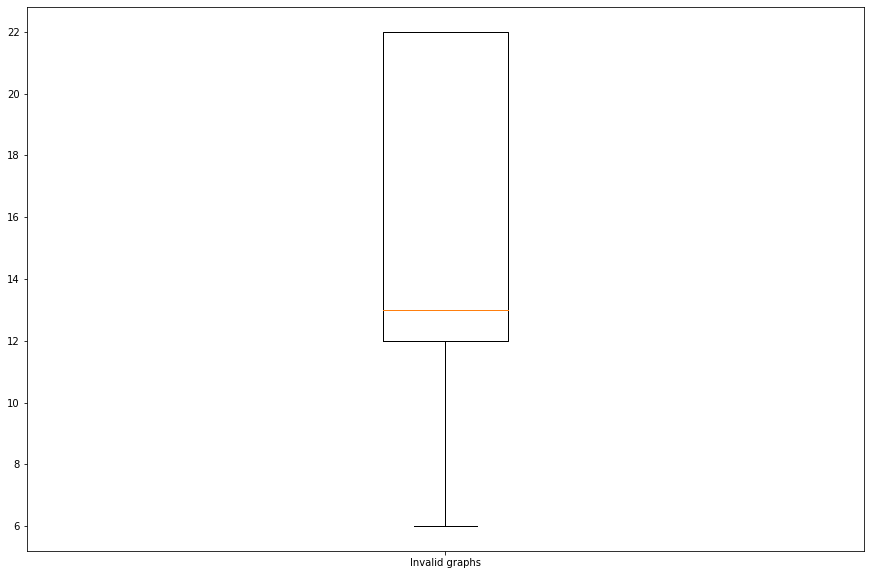

In [27]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.figure(figsize=(15,10))
plt.boxplot([invalid_nn_list],
           labels=['Invalid graphs'])

###Maximum Mean Discrepancy

Maximum Mean Discrepancy(MMD) compares two probability distributions and reports how far they are apart. We evaluate the following metrics only on valid graphs in order to eliminate the discrepancy caused by invalid graphs.

\begin{equation}
    \operatorname{MMD}^{2}(p \| q) =\mathbb{E}_{x, y \sim p}[k(x, y)] + \mathbb{E}_{x, y \sim q}[k(x, y)] - 2 \mathbb{E}_{x \sim p, y \sim q}[k(x, y)]
\end{equation}


In [28]:
MMD_num_of_nodes_list = list()
for metrics in structure_evaluation_metrics_list:
    MMD_num_of_nodes_list.append(metrics['dev']['num_nodes'])
MMD_num_of_nodes_list = np.array(MMD_num_of_nodes_list)
print("Maximum MMD distance between number of nodes in the validation and generated set ", np.max(MMD_num_of_nodes_list))
print("Minimum MMD distance between number of nodes in the validation and generated set ", np.min(MMD_num_of_nodes_list))
print("Average MMD distance between number of nodes in the validation and generated set ", np.mean(MMD_num_of_nodes_list))
print("Standard deviation of MMD distance between number of nodes in the validation and generated set ", np.std(MMD_num_of_nodes_list))

Maximum MMD distance between number of nodes in the validation and generated set  0.0
Minimum MMD distance between number of nodes in the validation and generated set  0.0
Average MMD distance between number of nodes in the validation and generated set  0.0
Standard deviation of MMD distance between number of nodes in the validation and generated set  0.0


In [29]:
MMD_node_degree_list = list()
for metrics in structure_evaluation_metrics_list:
    MMD_node_degree_list.append(metrics['dev']['node_degree'])
MMD_node_degree_list = np.array(MMD_node_degree_list)
print("Maximum MMD distance between node degree in the validation and generated set ", np.max(MMD_node_degree_list))
print("Minimum MMD distance between node degree in the validation and generated set ", np.min(MMD_node_degree_list))
print("Average MMD distance between node degree in the validation and generated set ", np.mean(MMD_node_degree_list))
print("Standard deviation of MMD distance between node degree in the validation and generated set ", np.std(MMD_node_degree_list))

Maximum MMD distance between node degree in the validation and generated set  0.011451229009241004
Minimum MMD distance between node degree in the validation and generated set  -1.3680477957800363e-05
Average MMD distance between node degree in the validation and generated set  0.0041471304059187645
Standard deviation of MMD distance between node degree in the validation and generated set  0.00390293048838808


In [30]:
MMD_node_clustering_list = list()
for metrics in structure_evaluation_metrics_list:
    MMD_node_clustering_list.append(metrics['dev']['node_clustering'])
MMD_node_clustering_list = np.array(MMD_node_clustering_list)
print("Maximum MMD distance between node clustering in the validation and generated set ", np.max(MMD_node_clustering_list))
print("Minimum MMD distance between node clustering in the validation and generated set ", np.min(MMD_node_clustering_list))
print("Average MMD distance between node clustering in the validation and generated set ", np.mean(MMD_node_clustering_list))
print("Standard deviation of MMD distance between node clustering in the validation and generated set ", np.std(MMD_node_clustering_list))

Maximum MMD distance between node clustering in the validation and generated set  0.0638851437915377
Minimum MMD distance between node clustering in the validation and generated set  0.023828963371404333
Average MMD distance between node clustering in the validation and generated set  0.03427743474095159
Standard deviation of MMD distance between node clustering in the validation and generated set  0.01506229920578846


In [31]:
MMD_graph_spectrum_list = list()
for metrics in structure_evaluation_metrics_list:
    MMD_graph_spectrum_list.append(metrics['dev']['graph_spectral'])
MMD_graph_spectrum_list = np.array(MMD_graph_spectrum_list)
print("Maximum MMD distance between graph laplacian in the validation and generated set ", np.max(MMD_graph_spectrum_list))
print("Minimum MMD distance between graph laplacian in the validation and generated set ", np.min(MMD_graph_spectrum_list))
print("Average MMD distance between graph laplacian in the validation and generated set ", np.mean(MMD_graph_spectrum_list))
print("Standard deviation of MMD distance between graph laplacian in the validation and generated set ", np.std(MMD_graph_spectrum_list))

Maximum MMD distance between graph laplacian in the validation and generated set  0.008811470357078077
Minimum MMD distance between graph laplacian in the validation and generated set  0.006392935136162237
Average MMD distance between graph laplacian in the validation and generated set  0.008044510728962085
Standard deviation of MMD distance between graph laplacian in the validation and generated set  0.0009320295463801902


###Accuracy

Let us review the the test accuracy of the valid graphs. In the following list, each value is the mean of the test accuracy of the generated graphs for the GRAN model generated with a random seed.

In [32]:
test_accuracy_list = list()
for folder_name in experiment_folder_list:
    folder_name = os.path.join(base_path, folder_name)
    file_name = os.path.join(folder_name, 'generated_graph_test_accuracy_list.p')
    if os.path.exists(file_name):
        generated_graph_test_accuracy_list = pickle.load(open(file_name, 'rb'))
        test_accuracy_list.append(sum(generated_graph_test_accuracy_list)/len(generated_graph_test_accuracy_list))
test_accuracy_list = np.array(test_accuracy_list)
print("Maximum test accuracy of valid graphs generated ", np.max(test_accuracy_list))
print("Minimum test accuracy of valid graphs generated ", np.min(test_accuracy_list))
print("Average test accuracy of valid graphs generated ", np.mean(test_accuracy_list))
print("Standard deviation of the test accuracy of valid graphs generated ", np.std(test_accuracy_list))

Maximum test accuracy of valid graphs generated  0.9110020465321012
Minimum test accuracy of valid graphs generated  0.9062711613278993
Average test accuracy of valid graphs generated  0.9090195554065511
Standard deviation of the test accuracy of valid graphs generated  0.002050063161167898


###Uniqueness

Uniqueness measures the unique share of the generated graphs. Simply put, we calculate the graph similarity. If the generated graphs are diverse among the generated graphs, then the generative model produces unique graphs.

Graph edit distance measure tells us the minimum of edits in nodes and edges required in a graph to produce a corresponding isomorphic graph.

In [33]:
uniqueness_list = list()
for metrics in structure_evaluation_metrics_list:
    if 'uniqueness' in metrics.keys():
        uniqueness_list.append(metrics['uniqueness'])

graph_edit_distance_distribution = dict()
for metric in uniqueness_list:
    for key in metric.keys():
        if key in graph_edit_distance_distribution.keys():
            graph_edit_distance_distribution[key] += metric[key]
        else:
            graph_edit_distance_distribution[key] = metric[key]

for key in graph_edit_distance_distribution.keys():
    graph_edit_distance_distribution[key] = graph_edit_distance_distribution[key]/8 # 8 represent the number of evaluations

for key in sorted(graph_edit_distance_distribution):
    print(f"{key}: {graph_edit_distance_distribution[key]}")

0: 0.6439393939393939
1: 5.12121212121212
2: 17.303030303030305
3: 23.573232323232325
4: 13.141414141414142
5: 2.558080808080808
6: 0.1590909090909091


###Novelty

We measure novelty as the valid number of generated graphs not available in the training dataset.

As defined earlier, graph edit distance measure the number of changes required to make one graph isomorphic to another graph. The graph edit distance metric will measure the novelty as the number of changes in the generated graphs to create the same graph in the training set. Therefore, the more the graph edit distance, the more the novelty of the graph generation model.

In [34]:
novelty_list = list()
for metrics in structure_evaluation_metrics_list:
    if 'novelty' in metrics.keys():
        novelty_list.append(metrics['novelty'])
graph_edit_distance_distribution = dict()
for metric in novelty_list:
    for key in metric.keys():
        if key in graph_edit_distance_distribution.keys():
            graph_edit_distance_distribution[key] += metric[key]
        else:
            graph_edit_distance_distribution[key] = metric[key]
for key in graph_edit_distance_distribution.keys():
    graph_edit_distance_distribution[key] = graph_edit_distance_distribution[key]/8 # 8 represent the number of evaluations
for key in sorted(graph_edit_distance_distribution):
    print(f"{key}: {graph_edit_distance_distribution[key]}")

0: 0.7051562499999999
1: 5.94421875
2: 17.5275
3: 23.92234375
4: 12.24515625
5: 2.04
6: 0.1146875
7: 0.0009375


###Visual Analysis using PyDot

We provide a simple interface to visualize the generated graphs.

In [35]:
from IPython.display import SVG
selected_experiment_folder_name = '9670'
selected_experiment_folder_name = os.path.join(base_path, selected_experiment_folder_name)

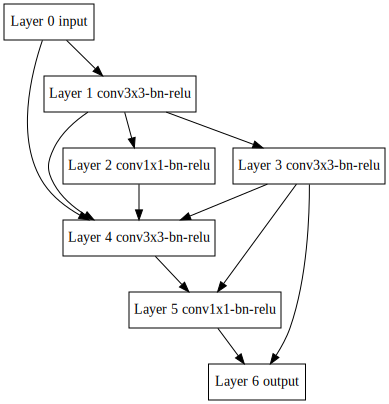

In [36]:
selected_graph_name = "invalid_architecture_99.svg" # graphs are numbered from 0 to 99
file_name = os.path.join(selected_experiment_folder_name, selected_graph_name)
SVG(file_name)

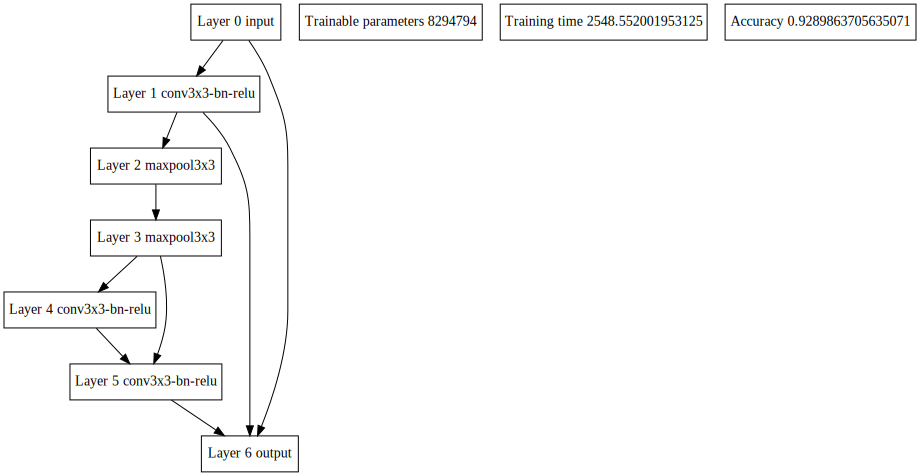

In [37]:
selected_graph_name = "valid_architecture_93.svg" # graphs are numbered from 0 to 99
file_name = os.path.join(selected_experiment_folder_name, selected_graph_name)
SVG(file_name)